In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv
/kaggle/input/glove-6b-100d-txt/glove.6B.100d.txt


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2024-04-28 08:49:02.343526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 08:49:02.343647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 08:49:02.492294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
test = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
sub = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv')
train

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


In [4]:
num_classes = len(train['score'].unique())
num_classes

6

In [5]:
!pip install -U -q sentencepiece

In [6]:
with open('./input.txt', 'w') as f:
    for line in train['full_text'].values:
        try:
            f.write(line)
        except:
            print("write error ---> ", line)

In [7]:
#write 가 잘 되었는지 확인
with open('./input.txt', 'r') as f:
    txt = f.read().split('\n')

print(len(txt))
print(txt[0])

137259
Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely "car free" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where 

In [8]:
import sentencepiece as spm

spm.SentencePieceTrainer.Train('--input=input.txt --model_prefix=spm --vocab_size=10000')
sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format('spm'))

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=input.txt --model_prefix=spm --vocab_size=10000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: input.txt
  input_format: 
  model_prefix: spm
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_p

True

al_privacy_noise_level: 0
  differential_privacy_clipping_threshold: 0
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(353) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(185) LOG(INFO) Loading corpus: input.txt
trainer_interface.cc(380) LOG(WARNING) Found too long line (7759 > 4192).
trainer_interface.cc(382) LOG(WARNING) Too long lines are skipped in the training.
trainer_interface.cc(383) LOG(WARNING) The maximum length can be changed with --max_sentence_length=<size> flag.
trainer_interface.cc(409) LOG(INFO) Loaded all 68585 sentences
trainer_interface.cc(416) LOG(INFO) Skipped 47 too long sentences.
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(425) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc

In [9]:
train_texts = [sp.encode_as_ids(t) for t in train['full_text'].values]
test_texts = [sp.encode_as_ids(t) for t in test['full_text'].values]

In [10]:
# 가장 긴 문장 길이 알아보기 (train과 test데이터 모두에서)
max([len(s) for s in train_texts] + [len(s) for s in test_texts]) #각각의 문장들의 길이를 쭈우욱 출력

1824

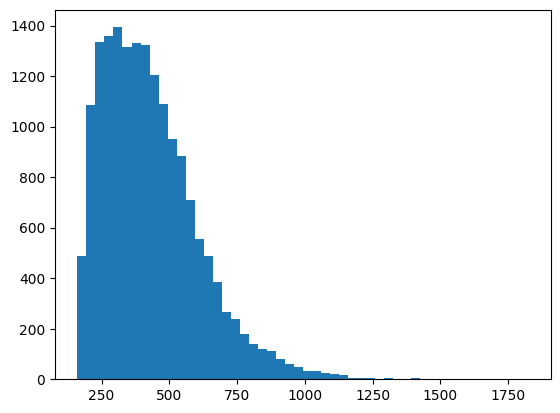

In [11]:
# 히스토그램 빈도수
plt.hist([len(s) for s in train_texts] + [len(s) for s in test_texts], bins=50); #간격 조정 50

In [12]:
train_texts = pd.DataFrame(train_texts)
test_texts = pd.DataFrame(test_texts)

In [13]:
train_x, val_x, train_y, val_y = train_test_split(train_texts, train['score'], test_size = 0.2, random_state = 42)

print(train_x.shape)
print(val_x.shape)
print(train_y.shape)
print(val_y.shape)

(13845, 1824)
(3462, 1824)
(13845,)
(3462,)


In [14]:
from tensorflow.keras.utils import to_categorical

train_y -= 1
val_y -= 1

# to_categorical 함수를 사용하여 원-핫 인코딩 적용
train_y = to_categorical(train_y, num_classes=num_classes)
val_y = to_categorical(val_y, num_classes=num_classes)

In [15]:
def make_embedding(num_words, embedding_dim, vocab_size):

    embeddings_dict = {}
    output = '/kaggle/input/glove-6b-100d-txt/glove.6B.100d.txt'
    
    with open(output, encoding="utf8") as f:
        for i, line in enumerate(f):
            values = line.split()            # 각 줄을 읽어와서 word_vector에 저장
            word = values[0]                 # 첫번째 값은 word
            # 두번째 element 부터 마지막까지 100 개는 해당 단어의 임베딩 벡터의  값
            coefs = np.asarray(values[1:], dtype='float32')  
            embeddings_dict[word] = coefs
                
    embedding_matrix = np.random.uniform(-0.25, 0.25, (num_words, embedding_dim))  # zero 로 초기화   
    
    print("word 갯수 =", num_words)
    print(embedding_matrix.shape)
    
    # SentencePiece 모델의 인덱스 정보 얻기
    #word_index = {word: sp.PieceToId(word) for word in sp}

    for i in range(vocab_size):  # SentencePiece 어휘집을 반복하면서
        word = sp.id_to_piece(i)
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
                    
    return embedding_matrix

In [16]:
vocab_size = 10000
EMBEDDING_DIM = 100
# create embedding matrix
embedding_matrix = make_embedding(vocab_size+1, EMBEDDING_DIM, 
                                vocab_size)
print(embedding_matrix.shape, type(embedding_matrix))

word 갯수 = 10001
(10001, 100)
(10001, 100) <class 'numpy.ndarray'>


In [17]:
import keras
print(keras.__version__)

3.2.1


In [19]:
# input layer
inputs = Input(shape=(None,))

# Embedding layer 
embedding_layer = Embedding(vocab_size+1, EMBEDDING_DIM, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

dropout_emb = Dropout(0.2)(embedding_layer(inputs))
lstm = Bidirectional(LSTM(100))(dropout_emb)
dropout_lstm = Dropout(0.2)(lstm)
dense_layer1 = Dense(64, activation='relu')(dropout_lstm)
dropout_dense = Dropout(0.2)(dense_layer1)

# output layer
outputs = Dense(num_classes, activation='softmax')(dropout_dense)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 100)      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200)            │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,174,154 (4.48 MB)

 Trainable params: 1,174,154 (4.48 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
%%time
num_epochs = 60
history = model.fit(train_x, train_y, epochs=num_epochs, batch_size=512,
                validation_data=(val_x, val_y), verbose=1)

Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 577ms/step - accuracy: 0.1435 - loss: 1.7621 - val_accuracy: 0.3654 - val_loss: 1.6025
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 562ms/step - accuracy: 0.3532 - loss: 1.5716 - val_accuracy: 0.3654 - val_loss: 1.4786
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 563ms/step - accuracy: 0.3399 - loss: 1.4905 - val_accuracy: 0.3654 - val_loss: 1.4622
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 562ms/step - accuracy: 0.3415 - loss: 1.4732 - val_accuracy: 0.3654 - val_loss: 1.4592
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 562ms/step - accuracy: 0.3296 - loss: 1.4862 - val_accuracy: 0.3654 - val_loss: 1.4573
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 562ms/step - accuracy: 0.3508 - loss: 1.4699 - val_accuracy: 0.3654 - val_loss: 1.4548
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 562ms/step - accuracy: 0.3473 - loss: 1.4722 - val_accuracy: 0.3654 - val_loss: 1.4515
Epoch 8/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 561ms/step - accuracy: 0.3481 - loss: 1.4646 - val_accu

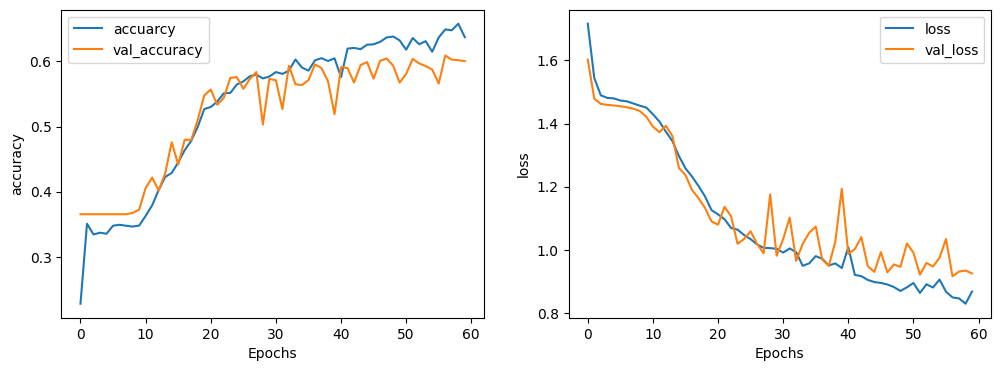

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) #ax1, ax2 두개의 축

ax1.plot(history.history['accuracy'], label = 'accuracy')
ax1.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()

In [22]:
result = model.predict(test_texts)
print(result)
print(result.argmax(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
[[3.1029567e-02 6.4467549e-01 3.1514689e-01 8.2347114e-03 6.5301068e-04
  2.6029872e-04]
 [6.3395961e-03 2.3956040e-01 7.2268575e-01 3.0269794e-02 9.0936583e-04
  2.3505763e-04]
 [5.4374565e-03 1.3194623e-02 1.3101085e-01 5.2778417e-01 2.8373700e-01
  3.8835920e-02]]
[1 2 3]


In [23]:
sub['score'] = result.argmax(1)
sub['score'] += 1
sub.to_csv('submission.csv', index = False)